# 使用Gluon对CIFAR10进行分类

In [1]:
import mxnet as mx
import numpy as np
import utils
import shutil
import os
import logging
logging.basicConfig(level=logging.INFO)

from mxnet import nd
from mxnet import gluon
from mxnet import image 
from mxnet import metric
from mxnet import autograd

%matplotlib inline 
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
import matplotlib.pyplot as plt

mx.random.seed(2018)

## 整理数据

In [2]:
def reorg_cifar10(data_dir, train_dir, test_dir, input_dir, label_file, valid_ratio):
    # 整理label
    with open(os.path.join(data_dir, label_file), 'r') as f:
        label_file = f.readlines()[1:]
        tokens = [l.rstrip().split(',') for l in label_file]
        idx_label = dict((int(idx), label) for idx, label in tokens)
    labels = set(idx_label.values())
    
    # 设置验证集比例
    num_train = len(os.listdir(os.path.join(data_dir, train_dir)))
    num_train_tuning = num_train * (1 - valid_ratio)
    assert 0 < num_train_tuning < num_train
    num_train_tuning_per_label = num_train_tuning // len(labels)
    
    # 整理训练集和验证集
    label_count = dict()
    def mkdir_if_not_exist(path):
        if not os.path.exists(os.path.join(*path)):
            os.makedirs(os.path.join(*path))
            
    for train_file in os.listdir(os.path.join(data_dir, train_dir)):
        idx = int(train_file.split('.')[0])
        train_label = idx_label[idx]
        mkdir_if_not_exist([data_dir, input_dir, 'train_valid', train_label])
        shutil.copy(os.path.join(data_dir, train_dir, train_file),
                   os.path.join(data_dir, input_dir, 'train_valid', train_label))
        # 划分训练集和验证集
        if train_label not in label_count or label_count[train_label] < num_train_tuning_per_label:
            mkdir_if_not_exist([data_dir, input_dir, 'train', train_label])
            shutil.copy(os.path.join(data_dir, train_dir, train_file),
                       os.path.join(data_dir, input_dir, 'train', train_label))
            label_count[train_label] = label_count.get(train_label, 0) + 1
        else:
            mkdir_if_not_exist([data_dir, input_dir, 'valid', train_label])
            shutil.copy(os.path.join(data_dir, train_dir, train_file),
                       os.path.join(data_dir, input_dir, 'valid', train_label))
    
    # 整理测试集
    mkdir_if_not_exist([data_dir, input_dir, 'test', 'unknown'])
    for test_file in os.listdir(os.path.join(data_dir, test_dir)):  
        shutil.copy(os.path.join(data_dir, test_dir, test_file),
                   os.path.join(data_dir, input_dir, 'test', 'unknown'))

In [3]:
data_dir = 'data/kaggle_cifar10'
train_dir = 'train'
test_dir = 'test'
input_dir = 'train_valid_test'
label_file = 'trainLabels.csv'
valid_ratio = .1

if not os.path.exists(os.path.join(data_dir, input_dir, test_dir)):
    reorg_cifar10(data_dir, train_dir, test_dir, input_dir, label_file, valid_ratio)

## 读取数据并增广

In [4]:
train_augs = [
    # 该值为计算得出
    image.ColorNormalizeAug(mean=nd.array([0.4914, 0.4822, 0.4456]), 
                            std=nd.array([0.2023, 0.1994, 0.2010])),
    image.HorizontalFlipAug(.6),
    # image.RandomSizedCropAug((32, 32), 0.8, (0.5, 2))
    # image.BrightnessJitterAug(.5),
    # image.ColorJitterAug
]

test_augs = [
    image.ColorNormalizeAug(mean=nd.array([0.4914, 0.4822, 0.4465]), 
                            std=nd.array([0.2023, 0.1994, 0.2010]))
]

def transform(data, label, augs):
    img = data.astype(np.float32)
    for aug in augs:
        img = aug(img)
    img = img.clip(0, 255).transpose((2,0,1)) / 255
    return img, nd.array([label]).asscalar().astype(np.float32)

############################################################################
def transform_train(data, label):
    im = data.astype('float32') / 255
    im = image.imresize(im, 36, 36)
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0,
                        rand_crop=True, rand_resize=True, rand_mirror=True,
                        mean=np.array([0.4914, 0.4822, 0.4465]),
                        std=np.array([0.2023, 0.1994, 0.2010]),
                        brightness=0, contrast=0,
                        saturation=0, hue=0,
                        pca_noise=0, rand_gray=0, inter_method=2)
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2,0,1))
    return (im, nd.array([label]).asscalar().astype('float32'))

################################### 另一种方法
# def apply(img):
#     auglist = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0,rand_crop=True, rand_resize=True, rand_mirror=True,
#                                 mean=np.array([0.4914, 0.4822, 0.4465]),std=np.array([0.2023, 0.1994, 0.2010]),
#                                 brightness=0, contrast=0,saturation=0, hue=0,pca_noise=0, rand_gray=0, inter_method=2)
#     for aug in auglist:
#         img = aug(img)
#     return img

# def transform_train(imgs):
#     imgs = nd.pad(imgs, pad_width=(0,0,0,0,2,2,2,2), constant_value=0, mode='constant')
#     imgs = nd.transpose(imgs, (0,2,3,1))
#     imgs = nd.stack(*[apply(img) for img in imgs])
#     imgs = nd.transpose(imgs, (0,3,1,2))
#     return imgs
###################################

def transform_test(data, label):
    im = data.astype('float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32),
                        mean=np.array([0.4914, 0.4822, 0.4465]),
                        std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2,0,1))
    return (im, nd.array([label]).asscalar().astype('float32'))
############################################################################

input_str = data_dir + '/' + input_dir + '/'

# 读取数据
train_ds = gluon.data.vision.ImageFolderDataset(input_str + 'train', transform=transform_train)
valid_ds = gluon.data.vision.ImageFolderDataset(input_str + 'valid', transform=transform_test)
train_valid_ds = gluon.data.vision.ImageFolderDataset(input_str + 'train_valid', transform=transform_train)
test_ds = gluon.data.vision.ImageFolderDataset(input_str + 'test', transform=transform_test)

batch_size = 128
train_data = gluon.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, last_batch='keep')
valid_data = gluon.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True, last_batch='keep')
train_valid_data = gluon.data.DataLoader(train_valid_ds, batch_size=batch_size, last_batch='keep')
test_data = gluon.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, last_batch='keep')

(128, 3, 32, 32)


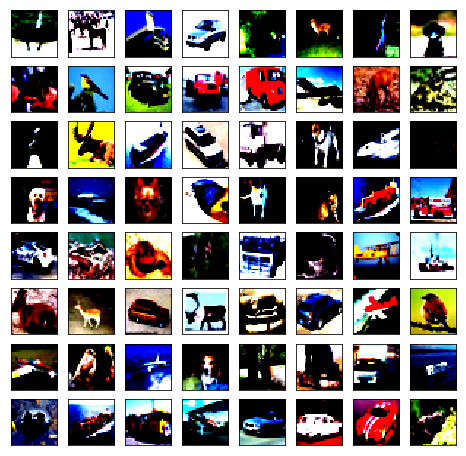

In [5]:
for data, label in valid_data:
    print(data.shape)
    break

utils.show_images(data.transpose((0,2,3,1)), 8, 8, figsize=(8,8))

## ResNet 164 v2

In [6]:
def BN_ReLU_Conv(num_filter, kernel_size, strides=1, padding=0, erase_relu=False, 
                 erase_conv=False, use_bias=False):
    '''
    num_filter : Int
        The output channel of this unit
    kernel_size : int
        Kernel size of the Conv kernel
    strides : int or tuple
        Conv strides
    padding : int or tuple
        Conv padding
    erase_relu : Boolean
        whether erase relu
    use_bias : Boolean
        Whether use bias
    '''
    unit = gluon.nn.HybridSequential()
    with unit.name_scope():
        unit.add(gluon.nn.BatchNorm(axis=1))
        if not erase_relu:
            unit.add(gluon.nn.Activation('relu'))
        if not erase_conv:
            unit.add(gluon.nn.Conv2D(num_filter, kernel_size=kernel_size, strides=strides, 
                                 padding=padding, use_bias=use_bias))
    return unit

def BN_ReLU(erase_relu=False):
    '''
    erase_relu : Boolean
        whether erase relu
    '''
    unit = gluon.nn.HybridSequential()
    with unit.name_scope():
        unit.add(gluon.nn.BatchNorm(axis=1))
        if not erase_relu:
            unit.add(gluon.nn.Activation('relu'))
    return unit

class Residual_Unit(gluon.nn.HybridBlock):
    def __init__(self, num_filter, strides, dim_match=True, bottle_neck=False, **kwargs):
        super().__init__(**kwargs)
        self.dim_match = dim_match
        self.bottle_neck = bottle_neck
        residual = self.residual = gluon.nn.HybridSequential()
        with self.name_scope():
            if bottle_neck:
                residual.add(BN_ReLU_Conv(int(num_filter * 0.25), kernel_size=1))  
                residual.add(BN_ReLU_Conv(int(num_filter * 0.25), kernel_size=3, strides=strides, padding=1))
                residual.add(BN_ReLU_Conv(num_filter, kernel_size=1))
            else:
                residual.add(BN_ReLU_Conv(num_filter, kernel_size=3, strides=strides, padding=1))
                residual.add(BN_ReLU_Conv(num_filter, kernel_size=3, strides=1, padding=1))
        if not dim_match:
            self.conv1 = gluon.nn.Conv2D(num_filter, kernel_size=1, strides=strides, use_bias=False)
            self.bn_relu = BN_ReLU()
    
    def hybrid_forward(self, F, X):
        if self.dim_match:
            shortcut = X
        else:
            shortcut = self.conv1(self.bn_relu(X))
        output = self.residual(X)
        return output + shortcut

class ResNet(gluon.nn.HybridBlock):
    def __init__(self, unit_list, filter_list, num_classes, data_type, bottle_neck=False, debug=False, **kwargs):
        '''
        unit_list : list
            num of unit per stage
        filter_list : list
            channnel size of each stage 
        num_classes : int
            num of classes
        bottle_neck : bool
            the bottle_neck archeitecture
        debug : bool
            print the shape of each stage 
        '''
        super().__init__(**kwargs)
        num_stage = len(unit_list)
        self.debug = debug
    
        resnet = self.resnet = gluon.nn.HybridSequential()
        with self.name_scope():
            # first layer 
            blk1 = gluon.nn.HybridSequential()
            blk1.add(gluon.nn.BatchNorm(axis=1))
            if data_type == 'cifar10':
                blk1.add(gluon.nn.Conv2D(filter_list[0], kernel_size=3, padding=1, use_bias=False))
            elif data_type == 'imagenet':
                blk1.add(
                    gluon.nn.Conv2D(filter_list[0], kernel_size=7, strides=2, padding=3, use_bias=False),
                    gluon.nn.BatchNorm(axis=1),
                    gluon.nn.Activation('relu'),
                    gluon.nn.MaxPool2D(pool_size=3, strides=2, padding=1)
                )
            else:
                raise ValueError('do not support {} yet.'.format(data_type))
            resnet.add(blk1)
            
            # residual layer 
            for i in range(num_stage):
                blk2 = gluon.nn.HybridSequential()
                blk2.add(Residual_Unit(filter_list[i+1], 1 if i==0 else 2, False, 
                                      bottle_neck=bottle_neck))
                for j in range(unit_list[i] - 1):
                    blk2.add(Residual_Unit(filter_list[i+1], 1, True, bottle_neck=bottle_neck))
                resnet.add(blk2)
            
            # regularizaiton layer 
            blk3 = gluon.nn.HybridSequential()
            blk3.add(
                gluon.nn.BatchNorm(axis=1),
                gluon.nn.Activation('relu')
            )
            resnet.add(blk3)
            
            # classification layer 
            blk4 = gluon.nn.HybridSequential()
            blk4.add(
                gluon.nn.GlobalAvgPool2D(),
                gluon.nn.Dense(num_classes)
            )
            resnet.add(blk4)

    def hybrid_forward(self, F, X):
        out = X
        for i, blk in enumerate(self.resnet):
            out = blk(out)
            # if self.debug:
                # print('blk {} : {}'.format(i+1, out.shape))
        return out

In [7]:
depth = 200

if (depth-2)%9 == 0 and depth >= 164:
    per_unit = [int((depth-2)/9)]
    filter_list = [16, 64, 128, 256]
    bottle_neck = True
elif (depth-2)%6 == 0 and depth < 164:
    per_unit = [int((depth-2)/6)]
    filter_list = [16, 16, 32, 64]
    bottle_neck = False
else:
    raise ValueError("depth {} error.".format(depth))
unit_list = per_unit * 3

symbol = ResNet(unit_list=unit_list, filter_list=filter_list, num_classes=10, 
                data_type='cifar10', bottle_neck=bottle_neck, debug=True)
symbol.initialize()
sample = nd.random.uniform(shape=(128, 3, 32, 32))
y = symbol(sample)

In [8]:
from time import time

def train(net, train_data, valid_data, num_epochs, lr, wd, lr_period, lr_decay, ctx):
    assert isinstance(ctx, mx.Context)
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'nag', {'learning_rate': lr, 'momentum': 0.9, 'wd': wd})
    niter = 0
    moving_loss = .0
    smoothing_constant = .9
    
    if valid_data is not None:
        best_valid_acc = .0
    for epoch in range(num_epochs):
        if 0 <= epoch <= 1:
            trainer.set_learning_rate(0.01)
        if epoch == 2:
            trainer.set_learning_rate(0.1)
        if epoch == 150:
            trainer.set_learning_rate(0.01)
        if epoch == 225:
            trainer.set_learning_rate(0.001)
        if epoch == 260:
            trainer.set_learning_rate(0.0001)
        if epoch == 280:
            trainer.set_learning_rate(0.00005)
        start = time()
        for data, label in train_data:
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            with autograd.record():
                output = net(data)
                l = loss(output, label)
            l.backward()
            trainer.step(data.shape[0])    
            
            niter += 1   
            curr_loss = nd.mean(l).asscalar()
            moving_loss = smoothing_constant * moving_loss + (1-smoothing_constant) * curr_loss
            estimated_loss = moving_loss / (1 - smoothing_constant**niter)
        
        train_acc = utils.evaluate_accuracy_gluon(train_data, net, ctx)
        
        if valid_data is not None:
            valid_acc, valid_loss = utils.evaluate_accuracy_gluon(valid_data, net, ctx, loss_avg=True)
            print("[Epoch %d] Train Moving Loss : %.5f, Test Loss : %.5f, Train Acc : %.5f, Test Acc : %.5f, Time Consume %f s."
                  % (epoch, estimated_loss, valid_loss, train_acc, valid_acc, time() - start))

            if valid_acc > best_valid_acc:
                best_valid_acc = valid_acc
                net.save_params('sparsenet-cifar10-%d.params' % (epoch))
        else:
            print("[Epoch %d] Train Moving Loss : %.5f, Train Acc : %.5f, Time Consume %f s."
                  % (epoch, estimated_loss,train_acc, time() - start))

In [9]:
num_epochs = 300
lr = 0.1
wd = 1e-4
lr_period = 50
lr_decay = .2

ctx = mx.gpu()
symbol = ResNet(unit_list=unit_list, filter_list=filter_list, num_classes=10, 
                data_type='cifar10', bottle_neck=bottle_neck, debug=True)
symbol.collect_params().initialize(ctx=ctx, init=mx.init.Xavier(rnd_type='gaussian', factor_type='in'
                                                               , magnitude=2.))
symbol.hybridize()
train(symbol, train_data, valid_data, num_epochs, lr, wd, lr_period, lr_decay, ctx)

[Epoch 0] Train Moving Loss : 1.89552, Test Loss : 1.83476, Train Acc : 0.30107, Test Acc : 0.33460, Time Consume 186.953388 s.
[Epoch 1] Train Moving Loss : 1.77020, Test Loss : 1.71259, Train Acc : 0.34298, Test Acc : 0.37500, Time Consume 177.931192 s.
[Epoch 2] Train Moving Loss : 1.67198, Test Loss : 1.66882, Train Acc : 0.34920, Test Acc : 0.37640, Time Consume 177.768554 s.
[Epoch 3] Train Moving Loss : 1.51960, Test Loss : 1.34978, Train Acc : 0.47144, Test Acc : 0.51820, Time Consume 177.731104 s.
[Epoch 4] Train Moving Loss : 1.34781, Test Loss : 1.36497, Train Acc : 0.50211, Test Acc : 0.52380, Time Consume 177.571433 s.
[Epoch 5] Train Moving Loss : 1.21039, Test Loss : 1.03845, Train Acc : 0.55309, Test Acc : 0.63320, Time Consume 177.402025 s.
[Epoch 6] Train Moving Loss : 1.12093, Test Loss : 0.99664, Train Acc : 0.59231, Test Acc : 0.65220, Time Consume 176.991119 s.
[Epoch 7] Train Moving Loss : 1.04514, Test Loss : 0.92088, Train Acc : 0.60540, Test Acc : 0.68320, Tim

[Epoch 64] Train Moving Loss : 0.57123, Test Loss : 0.59274, Train Acc : 0.76333, Test Acc : 0.82060, Time Consume 156.429967 s.
[Epoch 65] Train Moving Loss : 0.60138, Test Loss : 0.41585, Train Acc : 0.80827, Test Acc : 0.86360, Time Consume 156.491045 s.
[Epoch 66] Train Moving Loss : 0.54235, Test Loss : 0.37953, Train Acc : 0.79762, Test Acc : 0.87360, Time Consume 156.353868 s.
[Epoch 67] Train Moving Loss : 0.55190, Test Loss : 0.38769, Train Acc : 0.79884, Test Acc : 0.87660, Time Consume 156.595069 s.
[Epoch 68] Train Moving Loss : 0.55223, Test Loss : 0.37268, Train Acc : 0.78962, Test Acc : 0.87480, Time Consume 156.567133 s.
[Epoch 69] Train Moving Loss : 0.56017, Test Loss : 0.46623, Train Acc : 0.78773, Test Acc : 0.83740, Time Consume 156.389787 s.
[Epoch 70] Train Moving Loss : 0.53822, Test Loss : 0.44233, Train Acc : 0.79949, Test Acc : 0.86060, Time Consume 156.429841 s.
[Epoch 71] Train Moving Loss : 0.54260, Test Loss : 0.38231, Train Acc : 0.79460, Test Acc : 0.86

[Epoch 128] Train Moving Loss : 0.47692, Test Loss : 0.47090, Train Acc : 0.77800, Test Acc : 0.84620, Time Consume 173.514642 s.
[Epoch 129] Train Moving Loss : 0.49429, Test Loss : 0.34854, Train Acc : 0.80933, Test Acc : 0.87840, Time Consume 173.503116 s.
[Epoch 130] Train Moving Loss : 0.49816, Test Loss : 0.37586, Train Acc : 0.82593, Test Acc : 0.87680, Time Consume 173.595121 s.
[Epoch 131] Train Moving Loss : 0.50949, Test Loss : 0.47256, Train Acc : 0.81524, Test Acc : 0.84880, Time Consume 173.382048 s.
[Epoch 132] Train Moving Loss : 0.49043, Test Loss : 0.32676, Train Acc : 0.81711, Test Acc : 0.89040, Time Consume 173.459765 s.
[Epoch 133] Train Moving Loss : 0.49461, Test Loss : 0.37291, Train Acc : 0.83027, Test Acc : 0.87860, Time Consume 173.504700 s.
[Epoch 134] Train Moving Loss : 0.49092, Test Loss : 0.33945, Train Acc : 0.83176, Test Acc : 0.88480, Time Consume 174.434269 s.
[Epoch 135] Train Moving Loss : 0.47647, Test Loss : 0.30364, Train Acc : 0.83489, Test Ac

[Epoch 192] Train Moving Loss : 0.26283, Test Loss : 0.25391, Train Acc : 0.92324, Test Acc : 0.92920, Time Consume 156.691419 s.
[Epoch 193] Train Moving Loss : 0.26508, Test Loss : 0.27119, Train Acc : 0.92416, Test Acc : 0.93080, Time Consume 156.653379 s.
[Epoch 194] Train Moving Loss : 0.23397, Test Loss : 0.23298, Train Acc : 0.92524, Test Acc : 0.93260, Time Consume 156.592219 s.
[Epoch 195] Train Moving Loss : 0.23326, Test Loss : 0.24315, Train Acc : 0.92264, Test Acc : 0.93380, Time Consume 156.502415 s.
[Epoch 196] Train Moving Loss : 0.24143, Test Loss : 0.24788, Train Acc : 0.92553, Test Acc : 0.93240, Time Consume 156.590888 s.
[Epoch 197] Train Moving Loss : 0.22095, Test Loss : 0.23509, Train Acc : 0.92442, Test Acc : 0.93580, Time Consume 156.980390 s.
[Epoch 198] Train Moving Loss : 0.24676, Test Loss : 0.24600, Train Acc : 0.92349, Test Acc : 0.92980, Time Consume 157.178560 s.
[Epoch 199] Train Moving Loss : 0.24135, Test Loss : 0.25707, Train Acc : 0.92071, Test Ac

[Epoch 256] Train Moving Loss : 0.19011, Test Loss : 0.22864, Train Acc : 0.93956, Test Acc : 0.93880, Time Consume 156.337256 s.
[Epoch 257] Train Moving Loss : 0.19213, Test Loss : 0.21696, Train Acc : 0.94133, Test Acc : 0.94020, Time Consume 156.407885 s.
[Epoch 258] Train Moving Loss : 0.18166, Test Loss : 0.22128, Train Acc : 0.94016, Test Acc : 0.93780, Time Consume 156.411256 s.
[Epoch 259] Train Moving Loss : 0.17855, Test Loss : 0.22593, Train Acc : 0.94018, Test Acc : 0.93960, Time Consume 156.380003 s.
[Epoch 260] Train Moving Loss : 0.19270, Test Loss : 0.22392, Train Acc : 0.94136, Test Acc : 0.93920, Time Consume 156.460877 s.
[Epoch 261] Train Moving Loss : 0.20623, Test Loss : 0.23270, Train Acc : 0.94300, Test Acc : 0.94120, Time Consume 156.446641 s.
[Epoch 262] Train Moving Loss : 0.17617, Test Loss : 0.22075, Train Acc : 0.94082, Test Acc : 0.93940, Time Consume 156.313635 s.
[Epoch 263] Train Moving Loss : 0.19231, Test Loss : 0.22585, Train Acc : 0.94227, Test Ac

In [10]:
import pandas as pd

ctx = mx.gpu()
num_epochs = 300
lr = 0.1
wd = 1e-4
lr_period = 50
lr_decay = .2

ctx = mx.gpu()
symbol = ResNet(unit_list=unit_list, filter_list=filter_list, num_classes=10, 
                data_type='cifar10', bottle_neck=bottle_neck, debug=True)
symbol.collect_params().initialize(ctx=ctx, init=mx.init.Xavier(rnd_type='gaussian', factor_type='in'
                                                               , magnitude=2.))
symbol.hybridize()
train(symbol, train_data, None, num_epochs, lr, wd, lr_period, lr_decay, ctx)

[Epoch 0] Train Moving Loss : 1.92976, Train Acc : 0.27231, Time Consume 151.912474 s.
[Epoch 1] Train Moving Loss : 1.80926, Train Acc : 0.32973, Time Consume 151.920473 s.
[Epoch 2] Train Moving Loss : 1.70364, Train Acc : 0.33484, Time Consume 151.857628 s.
[Epoch 3] Train Moving Loss : 1.49136, Train Acc : 0.43547, Time Consume 151.769768 s.
[Epoch 4] Train Moving Loss : 1.36579, Train Acc : 0.50387, Time Consume 151.877070 s.
[Epoch 5] Train Moving Loss : 1.25002, Train Acc : 0.55982, Time Consume 151.894803 s.
[Epoch 6] Train Moving Loss : 1.10958, Train Acc : 0.61133, Time Consume 151.902740 s.
[Epoch 7] Train Moving Loss : 1.05159, Train Acc : 0.58891, Time Consume 151.901248 s.
[Epoch 8] Train Moving Loss : 1.00241, Train Acc : 0.63378, Time Consume 151.831120 s.
[Epoch 9] Train Moving Loss : 1.01837, Train Acc : 0.62222, Time Consume 151.764714 s.
[Epoch 10] Train Moving Loss : 0.91663, Train Acc : 0.65447, Time Consume 151.843524 s.
[Epoch 11] Train Moving Loss : 0.92101, Tr

[Epoch 94] Train Moving Loss : 0.51038, Train Acc : 0.81809, Time Consume 151.677211 s.
[Epoch 95] Train Moving Loss : 0.49550, Train Acc : 0.81033, Time Consume 151.917349 s.
[Epoch 96] Train Moving Loss : 0.51684, Train Acc : 0.80182, Time Consume 151.988956 s.
[Epoch 97] Train Moving Loss : 0.54002, Train Acc : 0.80573, Time Consume 151.863075 s.
[Epoch 98] Train Moving Loss : 0.51385, Train Acc : 0.80747, Time Consume 151.859527 s.
[Epoch 99] Train Moving Loss : 0.47152, Train Acc : 0.80724, Time Consume 151.911382 s.
[Epoch 100] Train Moving Loss : 0.52089, Train Acc : 0.78978, Time Consume 151.840620 s.
[Epoch 101] Train Moving Loss : 0.52705, Train Acc : 0.82296, Time Consume 151.924085 s.
[Epoch 102] Train Moving Loss : 0.52734, Train Acc : 0.81089, Time Consume 151.834023 s.
[Epoch 103] Train Moving Loss : 0.52565, Train Acc : 0.81611, Time Consume 151.869578 s.
[Epoch 104] Train Moving Loss : 0.55103, Train Acc : 0.80853, Time Consume 151.876446 s.
[Epoch 105] Train Moving Lo

[Epoch 187] Train Moving Loss : 0.23979, Train Acc : 0.92011, Time Consume 151.795463 s.
[Epoch 188] Train Moving Loss : 0.25365, Train Acc : 0.92436, Time Consume 151.810132 s.
[Epoch 189] Train Moving Loss : 0.23580, Train Acc : 0.92251, Time Consume 151.807284 s.
[Epoch 190] Train Moving Loss : 0.25305, Train Acc : 0.92391, Time Consume 151.896050 s.
[Epoch 191] Train Moving Loss : 0.24995, Train Acc : 0.92233, Time Consume 151.948546 s.
[Epoch 192] Train Moving Loss : 0.23907, Train Acc : 0.92133, Time Consume 151.726863 s.
[Epoch 193] Train Moving Loss : 0.23668, Train Acc : 0.92464, Time Consume 151.837245 s.
[Epoch 194] Train Moving Loss : 0.24906, Train Acc : 0.92142, Time Consume 151.846319 s.
[Epoch 195] Train Moving Loss : 0.24605, Train Acc : 0.92469, Time Consume 151.846570 s.
[Epoch 196] Train Moving Loss : 0.21851, Train Acc : 0.92280, Time Consume 151.802401 s.
[Epoch 197] Train Moving Loss : 0.21629, Train Acc : 0.92173, Time Consume 151.863303 s.
[Epoch 198] Train Mov

[Epoch 280] Train Moving Loss : 0.21067, Train Acc : 0.94251, Time Consume 151.768445 s.
[Epoch 281] Train Moving Loss : 0.16329, Train Acc : 0.94144, Time Consume 151.750983 s.
[Epoch 282] Train Moving Loss : 0.15736, Train Acc : 0.94142, Time Consume 151.787822 s.
[Epoch 283] Train Moving Loss : 0.16977, Train Acc : 0.94151, Time Consume 151.827309 s.
[Epoch 284] Train Moving Loss : 0.15837, Train Acc : 0.94120, Time Consume 151.803546 s.
[Epoch 285] Train Moving Loss : 0.18445, Train Acc : 0.94160, Time Consume 151.602496 s.
[Epoch 286] Train Moving Loss : 0.17720, Train Acc : 0.94136, Time Consume 151.840483 s.
[Epoch 287] Train Moving Loss : 0.16775, Train Acc : 0.94076, Time Consume 151.765371 s.
[Epoch 288] Train Moving Loss : 0.18219, Train Acc : 0.94067, Time Consume 151.845414 s.
[Epoch 289] Train Moving Loss : 0.18824, Train Acc : 0.94360, Time Consume 151.776284 s.
[Epoch 290] Train Moving Loss : 0.17580, Train Acc : 0.94240, Time Consume 151.852407 s.
[Epoch 291] Train Mov

In [11]:
preds = []
for data, label in test_data:
     output = symbol(data.as_in_context(ctx))
     preds.extend(output.argmax(axis=1).astype(int).asnumpy())

sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key = lambda x:str(x))

df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.synsets[x])
df.to_csv('submission.csv', index=False)

## 集中损失函数(Focal Loss)

论文地址：https://arxiv.org/abs/1708.02002

In [2]:
class FocalLoss(gluon.loss.Loss):
    def __init__(self, axis=-1, alpha=0.25, gamma=2, batch_axis=0, **kwargs):
        super(FocalLoss, self).__init__(None, batch_axis, **kwargs)
        self._axis = axis
        self._alpha = alpha
        self._gamma = gamma

    def hybrid_forward(self, F, output, label):
        output = F.softmax(output)
        pj = output.pick(label, axis=self._axis, keepdims=True)
        loss = - self._alpha * ((1 - pj) ** self._gamma) * pj.log()
        return loss.mean(axis=self._batch_axis, exclude=True)